# Лабораторная №1. Задача регрессии.

**Шкуратова Д.В. Б9122-01.03.02мкт**


# Import

In [3]:
import pandas as pd
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
from IPython.display import display

In [22]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Load Dataset
Датасет взят с [Kaggle](https://www.kaggle.com/competitions/critical-temperature-of-superconductors/overview) (Задача с Samsung Innovation Campus Bootcamp)

**Описание задачи:**
>Явление сверхпроводимость одно из самых удивительных по своей природе, но объяснить его с классической точки зрения невозможно.
Данное явление было открыто голландским физиком Хейке Камерлинг-Оннес в 1911 году.

>Сверхпроводимость — свойство некоторых веществ и материалов, электрическое сопротивление которых при понижении температуры до определенного уровня падает до нуля. Сверхпроводимость возникает скачком при понижении температуры. Температура при которой возникает скачок называется критической температурой.

>Несмотря на то, что сверхпроводимость была открыта больше века назад, многие её свойства плохо изучены, например, связь между сверхпроводимостью и химическими/структурными свойствами материалов.

>Вам предлагается разработать алгоритмы машинного обучения, которые позволяют установить связь между химическим составом, различными свойствами сверхпроводниками и их критической температурой.


In [5]:
df = pd.read_csv('data/train.csv')
formula = pd.read_csv('data/formula_train.csv')
phys_cols = df.columns
chem_cols = formula.columns
formula.drop(columns=['critical_temp'], inplace=True)
df = pd.concat([df, formula], axis=1)
df.head()

,number_of_elements,mean_atomic_mass,wtd_mean_atomic_mass,gmean_atomic_mass,wtd_gmean_atomic_mass,entropy_atomic_mass,wtd_entropy_atomic_mass,range_atomic_mass,wtd_range_atomic_mass,std_atomic_mass,...,Pt,Au,Hg,Tl,Pb,Bi,Po,At,Rn,material
0,4,88.944468,57.862692,66.361592,36.116612,1.181795,1.062396,122.90607,31.794921,51.968828,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,Ba0.2La1.8Cu1O4
1,5,92.729214,58.518416,73.132787,36.396602,1.449309,1.057755,122.90607,36.161939,47.094633,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,Ba0.1La1.9Ag0.1Cu0.9O4
2,4,88.944468,57.885242,66.361592,36.122509,1.181795,0.975980,122.90607,35.741099,51.968828,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,Ba0.1La1.9Cu1O4
3,4,88.944468,57.873967,66.361592,36.119560,1.181795,1.022291,122.90607,33.768010,51.968828,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,Ba0.15La1.85Cu1O4
4,4,88.944468,57.840143,66.361592,36.110716,1.181795,1.129224,122.90607,27.848743,51.968828,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,Ba0.3La1.7Cu1O4


In [5]:
formula.shape[1], df.shape[1] - formula.shape[1]

(87, 82)

# DA
Тренировочный датасет состоит из двух csv файлов:
- formula_train.csv
    - содержит химическую формулу сверхпроводника: колонки являются названиями хим. эл-в, строки содержат кол-во атомов соответствюшего эл-та
- train.csv 
    - содержит другие химические и физические свойства сверхпроводника

<Axes: xlabel='critical_temp', ylabel='Count'>

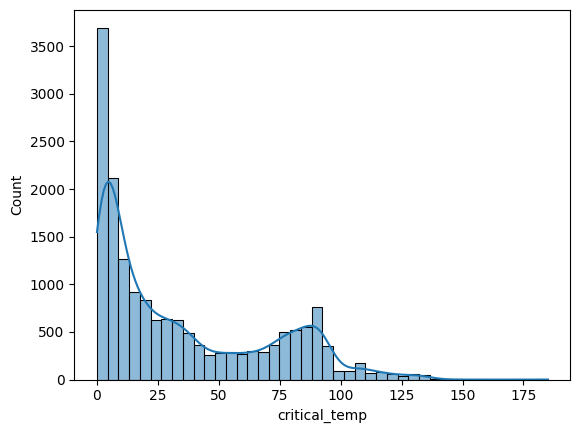

In [6]:
sns.histplot(df['critical_temp'], kde=True)

Для аналитического решения поиска коэффициентов линейной модели нужно удалить все высококоррелированные признаки и признаки равные нулевому вектору

In [7]:
df.describe()

,number_of_elements,mean_atomic_mass,wtd_mean_atomic_mass,gmean_atomic_mass,wtd_gmean_atomic_mass,entropy_atomic_mass,wtd_entropy_atomic_mass,range_atomic_mass,wtd_range_atomic_mass,std_atomic_mass,...,Ir,Pt,Au,Hg,Tl,Pb,Bi,Po,At,Rn
count,17010.000000,17010.000000,17010.000000,17010.000000,17010.000000,17010.000000,17010.000000,17010.000000,17010.000000,17010.000000,...,17010.000000,17010.000000,17010.000000,17010.000000,17010.000000,17010.000000,17010.000000,17010.0,17010.0,17010.0
mean,4.113874,87.534919,73.000381,71.308789,58.599393,1.165500,1.063972,115.443468,33.228642,44.320187,...,0.061441,0.035000,0.023379,0.036708,0.049646,0.042367,0.200175,0.0,0.0,0.0
std,1.437846,29.786319,33.730910,31.166777,36.902657,0.364607,0.401877,54.614167,27.104426,19.993413,...,0.872817,0.310635,0.800146,0.205809,0.279357,0.286488,0.656456,0.0,0.0,0.0
min,1.000000,6.941000,6.423452,5.320573,1.960849,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
25%,3.000000,72.383174,52.078254,58.001648,35.228269,0.966676,0.777721,78.353150,16.790394,32.890369,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
50%,4.000000,84.841880,60.547264,66.361592,39.821155,1.199541,1.148646,122.906070,26.585389,45.123500,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
75%,5.000000,100.404410,85.982586,78.116681,73.075297,1.444537,1.359836,154.119320,38.193007,58.973428,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
max,9.000000,208.980400,208.980400,208.980400,208.980400,1.983797,1.958203,207.972460,205.589910,101.019700,...,45.000000,5.000000,64.000000,8.000000,7.000000,19.000000,14.000000,0.0,0.0,0.0


In [8]:
df.drop(columns=['material'])
df['critical_temp'].describe()

count    17010.000000
mean        34.502993
std         34.334793
min          0.000210
25%          5.330000
50%         20.000000
75%         63.000000
max        185.000000
Name: critical_temp, dtype: float64

Рассмотрим распределения значений хим. эле-в по колонкам

In [9]:
formula.drop(columns=['material'], inplace=True)

In [10]:
pd.concat([formula.apply(lambda x: x.nunique()).to_frame('nunique'), 
           formula.apply(lambda x: x.min()).to_frame('min'),
           formula.apply(lambda x: x.quantile(0.25)).to_frame('Q25'),
           formula.apply(lambda x: x.quantile(0.5)).to_frame('Q50'),
           formula.apply(lambda x: x.quantile(0.75)).to_frame('Q75'),
           formula.apply(lambda x: x.max()).to_frame('max')], axis=1)
         

,nunique,min,Q25,Q50,Q75,max
H,106,0.0,0.0,0.0,0.0,14.0
He,1,0.0,0.0,0.0,0.0,0.0
Li,64,0.0,0.0,0.0,0.0,2.6
Be,40,0.0,0.0,0.0,0.0,40.0
B,92,0.0,0.0,0.0,0.0,105.0
...,...,...,...,...,...,...
Pb,142,0.0,0.0,0.0,0.0,19.0
Bi,144,0.0,0.0,0.0,0.0,14.0
Po,1,0.0,0.0,0.0,0.0,0.0
At,1,0.0,0.0,0.0,0.0,0.0


По значениям квартилей, минимальному и максимальному значению видим, что элементы, редко встречающиеся в составе материлов, есть элементы которые не встречаются совсе.
Удалим колонки содержащие нулевые столбцы

In [11]:
df = df.loc[:, ~df.eq(0).all()].drop(columns=['material'])

In [36]:
df.shape

(17010, 159)

В датасете все признаки вещественные, но есть колонка с кол-м элементов, содержащихся в материале, проверим не является ли она константой 

<Axes: xlabel='number_of_elements', ylabel='count'>

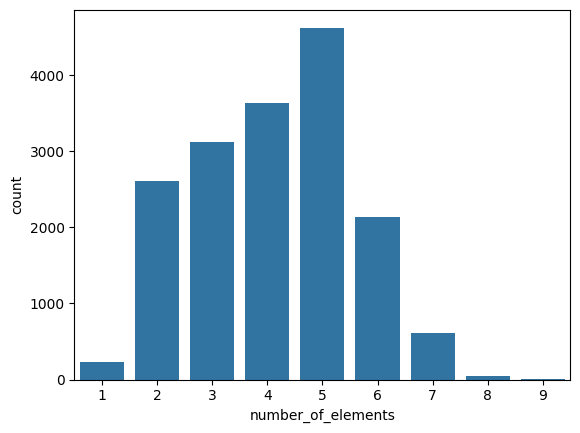

In [12]:
sns.countplot(df, x='number_of_elements')

В нашем датасете очень большое кол-во признаков, рассмотри корреляцию с целевой переменной, так как колонки с хим. элементам принимают только целочисленные значения, рассмотрим коэффициент с колонками из первой таблицы с физ. характеристиками

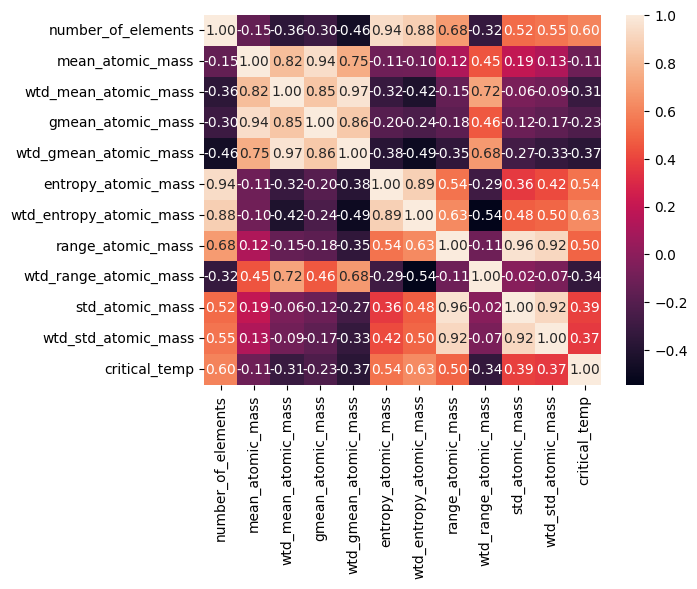

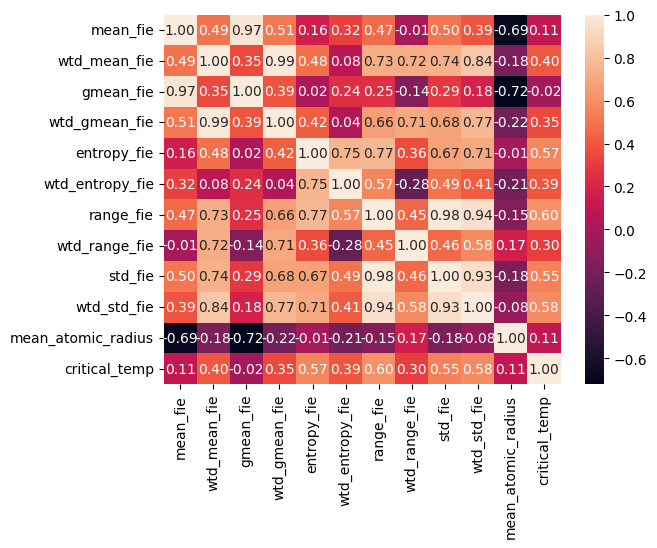

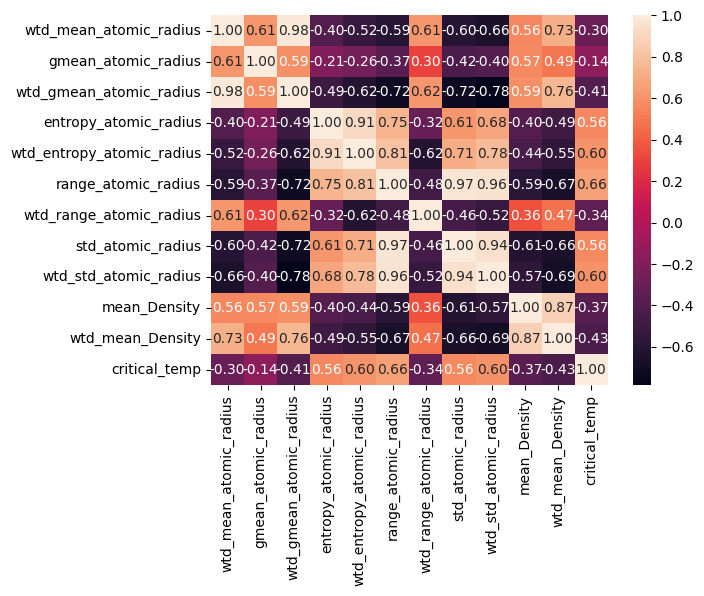

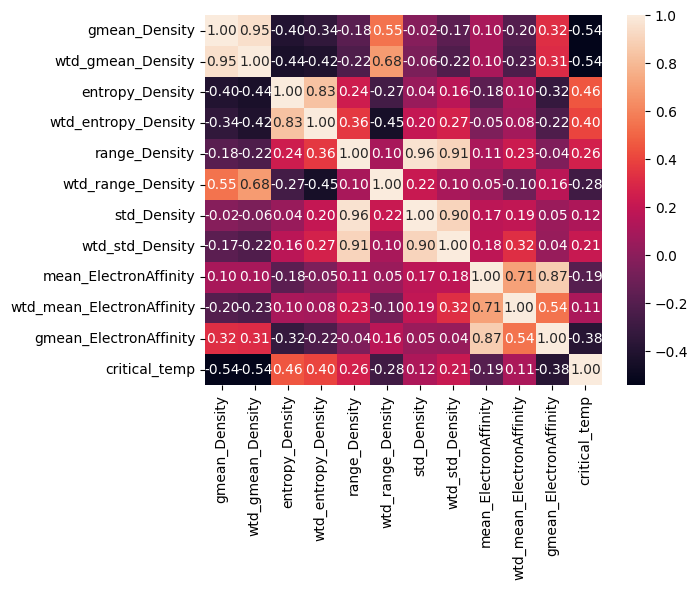

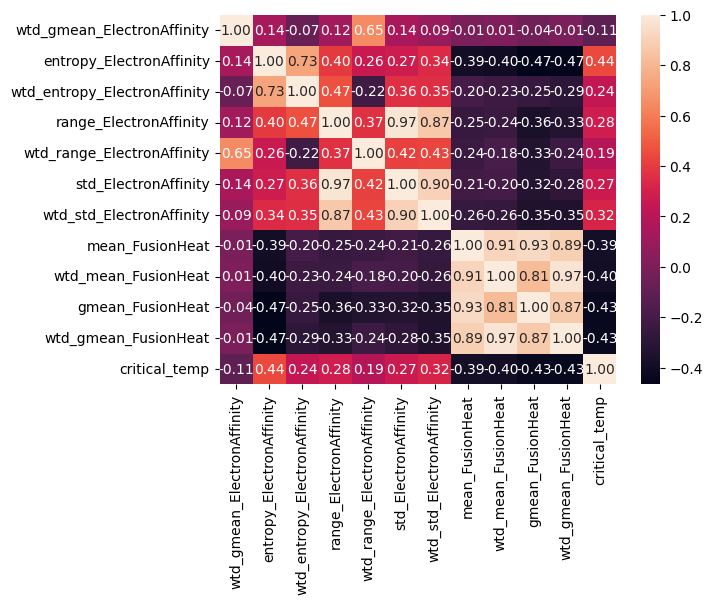

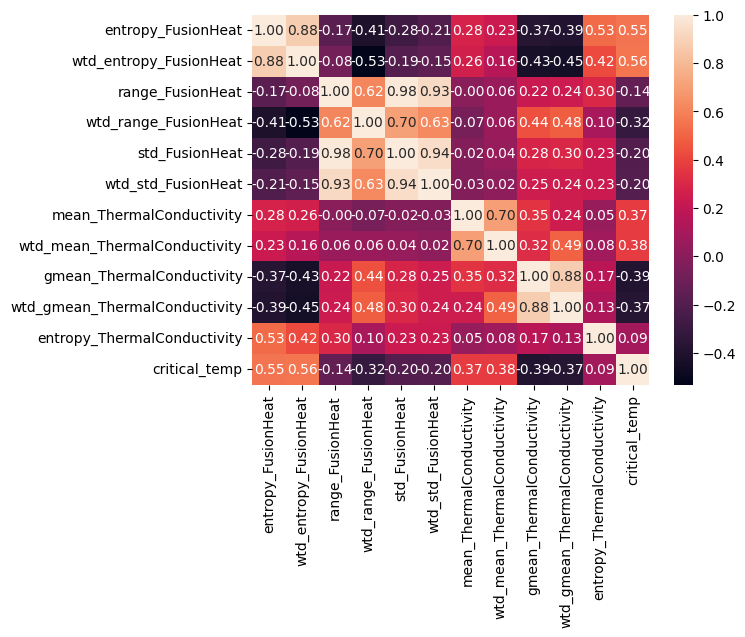

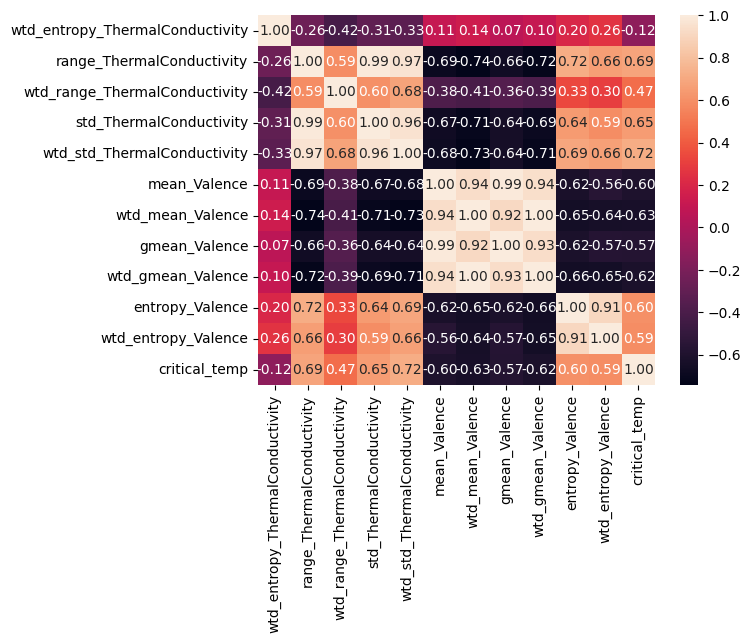

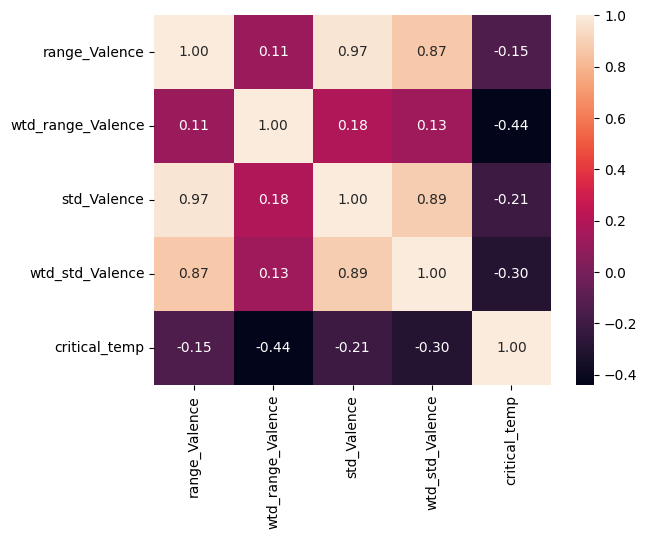

In [38]:
phys_cols = phys_cols.drop(['critical_temp']).to_list()
for i in range(0, len(phys_cols), 11):
    sns.heatmap(df[phys_cols[i:i +11] + ['critical_temp']].corr(numeric_only=True), annot=True, fmt='.2f')
    plt.show()

Получили, что целевая переменная имеет коэффициент корреляции > 0.5 с большим кол-м наблюдаемых признаков.
Но для построения линейной регрессии мы должны убедиться, что все нецелевые признаки не имеют высокую попарную корреляцию, иначе можем получить матрицу близкую к вырожденной. 

По выведеным срезам видим, что это не так,
рроверим получится ли воспользоваться аналитической формулой линейной регрессии, если нет, то будет фильтровать признаки по коэффициенту корреляции пока не получим коэффициенты весов. 

In [13]:
corr_df = df.corr()
corr_df = corr_df.abs().round(2)
ans = []
idx =[]
for col in corr_df.columns:
    ans.append(corr_df[col].drop(col).max())
    idx.append(corr_df[col].drop(col).idxmax())
pairs = pd.DataFrame({'feature':corr_df.columns, 'second_feature':idx, 'corr':ans})
pairs.sort_values('corr', ascending=False)

,feature,second_feature,corr
15,entropy_fie,entropy_atomic_radius,1.00
25,entropy_atomic_radius,entropy_fie,1.00
72,wtd_mean_Valence,wtd_gmean_Valence,1.00
74,wtd_gmean_Valence,wtd_mean_Valence,1.00
67,range_ThermalConductivity,std_ThermalConductivity,0.99
...,...,...,...
142,Ho,range_FusionHeat,0.09
120,Tc,wtd_mean_Valence,0.07
108,Zn,wtd_mean_ElectronAffinity,0.05
135,Pr,wtd_range_atomic_radius,0.04


In [14]:
pairs.value_counts('second_feature')

second_feature
C                                4
Ga                               4
wtd_mean_Valence                 4
mean_ElectronAffinity            4
entropy_fie                      4
                                ..
wtd_range_ThermalConductivity    1
wtd_range_atomic_mass            1
wtd_std_ElectronAffinity         1
wtd_std_atomic_radius            1
wtd_std_fie                      1
Name: count, Length: 97, dtype: int64

In [13]:
drop_col = ['entropy_fie', 'wtd_gmean_Valence']
#'wtd_gmean_ThermalConductivity', 'gmean_Valence', 'range_fie'
df = df.drop(columns=drop_col)

# Models

## Linear Model

In [15]:
class MyLinReg:
    def __init__(self,  intercept=True):
        self.intercept = intercept
    
    def fit(self, X: pd.DataFrame, y: pd.Series):
        if self.intercept:
            X['Intercept'] = np.ones(X.shape[0])
        self.features = X.columns
        self.X = X.values
        self.y = y.values 
        try:
            self.w = np.linalg.inv(self.X.T @ self.X) @ self.X.T @ self.y 
            return pd.DataFrame({'features':self.features, 'coef':self.w})
        except np.linalg.LinAlgError as e:
            print(f"Error: {e}")
        
    def predict(self, X):
        if self.intercept:
            X['Intercept'] = np.ones(X.shape[0])
        return X[self.features].values @ self.w 


def get_metric(y_true, y_pred, filter=False):
    if filter:
        y_pred = [0 if i < 0 else i for i in y_pred]
    mse = mean_squared_error(y_true, y_pred)
    rmse = mse ** (1/2)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return pd.DataFrame({
        'MSE':[mse],
        'RMSE':[rmse],
        'MAE':[mae],
        'R2':[r2]
    })


def get_pred_plot(y_true, y_pred, filter=False):
    if filter:
        y_pred = [0 if i < 0 else i for i in y_pred]
    fig, ax = plt.subplots(1, 2)
    sns.histplot(y_true, label='true', ax=ax[0])
    sns.histplot(y_pred, label='pred', ax=ax[0])
    ax[0].legend()
    sns.scatterplot(y=y_pred, x=y_true, ax=ax[1])
    sns.lineplot(y=y_true, x=y_true, ax=ax[1])
    plt.show()

### Train Test split

In [31]:
num_bins = 4
df['cat_feature'] = pd.cut(df['critical_temp'], num_bins, labels = [str(i) for i in range(num_bins)])

In [32]:
train, test = train_test_split(df, train_size=0.7, stratify=df['cat_feature'], random_state=714134)
X_col = df.columns.drop(['critical_temp', 'cat_feature'])
y_col = 'critical_temp'
my_lm = MyLinReg()
my_lm.fit(train[X_col], train[y_col])


C:\Users\Shkur\AppData\Local\Temp\ipykernel_9784\1711740912.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Intercept'] = np.ones(X.shape[0])


,features,coef
0,number_of_elements,1.533737
1,mean_atomic_mass,0.930758
2,wtd_mean_atomic_mass,-1.376323
3,gmean_atomic_mass,-0.459641
4,wtd_gmean_atomic_mass,0.862237
...,...,...
152,Hg,4.869648
153,Tl,6.166010
154,Pb,1.167759
155,Bi,5.718839


In [33]:
pd.concat([
    get_metric(train[y_col], my_lm.predict(train[X_col])),
    get_metric(test[y_col], my_lm.predict(test[X_col])),
])

C:\Users\Shkur\AppData\Local\Temp\ipykernel_9784\1711740912.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Intercept'] = np.ones(X.shape[0])
C:\Users\Shkur\AppData\Local\Temp\ipykernel_9784\1711740912.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Intercept'] = np.ones(X.shape[0])


,MSE,RMSE,MAE,R2
0,267.793104,16.364385,12.210116,0.772531
0,1784.876189,42.247795,13.244867,-0.509557


### Графики линейной регрессии с выбором порога и без

C:\Users\Shkur\AppData\Local\Temp\ipykernel_9784\1711740912.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Intercept'] = np.ones(X.shape[0])


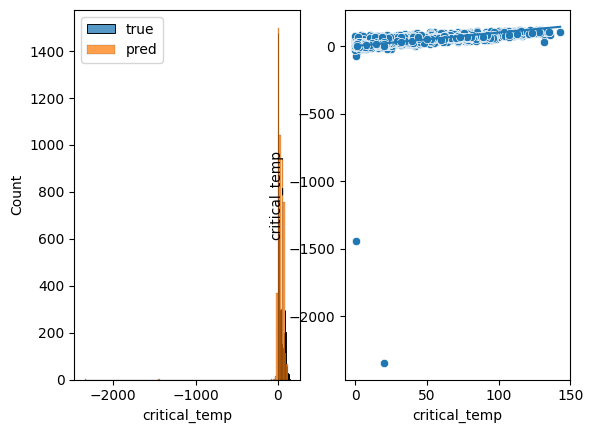

In [34]:
get_pred_plot(test[y_col], my_lm.predict(test[X_col]))

C:\Users\Shkur\AppData\Local\Temp\ipykernel_9784\1711740912.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Intercept'] = np.ones(X.shape[0])


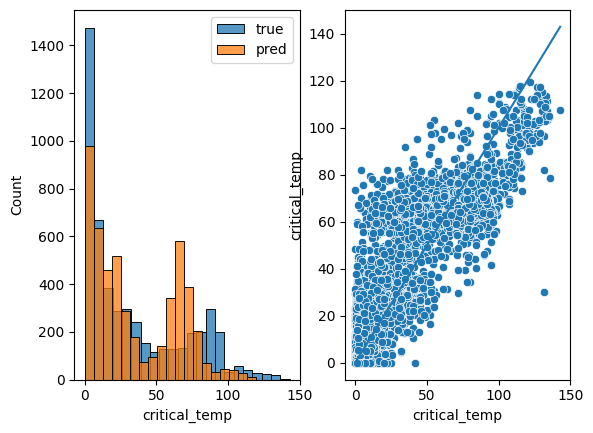

In [35]:
get_pred_plot(test[y_col], my_lm.predict(test[X_col]), filter=True)

In [36]:
get_metric(test[y_col], my_lm.predict(test[X_col]), filter=True)

C:\Users\Shkur\AppData\Local\Temp\ipykernel_9784\1711740912.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Intercept'] = np.ones(X.shape[0])


,MSE,RMSE,MAE,R2
0,266.574898,16.327122,11.980646,0.774545


## Sklearn Linar Models

In [37]:
lm = LinearRegression()
lasso = Lasso()
ridge = Ridge()

lm = LinearRegression()
lm.fit(train[X_col], train[y_col])
lasso.fit(train[X_col], train[y_col])
ridge.fit(train[X_col], train[y_col])


d:\xyz\Projects\MathVenv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.094e+06, tolerance: 1.402e+03
  model = cd_fast.enet_coordinate_descent(


,alpha,1.0
,fit_intercept,True
,copy_X,True
,max_iter,None
,tol,0.0001
,solver,'auto'
,positive,False
,random_state,None


In [38]:
reg_coef = pd.DataFrame({
    'feature_name':['Intercept'] +  lasso.feature_names_in_.tolist(),
    'my_lm_coef': [my_lm.w[-1]] + my_lm.w[:my_lm.w.shape[0] - 1].tolist(),
    'lm_coef':  [lm.intercept_] + lm.coef_.tolist(),
    'lasso_wi': [lasso.intercept_] + lasso.coef_.tolist(),
    'ridge_wi': [ridge.intercept_] + ridge.coef_.tolist(),
})
reg_coef

,feature_name,my_lm_coef,lm_coef,lasso_wi,ridge_wi
0,Intercept,-30.641536,-30.641536,-19.803063,-30.605975
1,number_of_elements,1.533737,1.533737,0.000000,1.120081
2,mean_atomic_mass,0.930758,0.930758,0.167498,0.922876
3,wtd_mean_atomic_mass,-1.376323,-1.376323,-0.011209,-1.355666
4,gmean_atomic_mass,-0.459641,-0.459641,0.000000,-0.467337
...,...,...,...,...,...
152,Au,-0.187765,-0.187765,-0.000000,-0.214942
153,Hg,4.869648,4.869648,0.000000,4.894663
154,Tl,6.166010,6.166010,0.000000,6.175121
155,Pb,1.167759,1.167759,-0.000000,1.098865


In [39]:
reg_coef.sort_values('lasso_wi', ascending=False)

,feature_name,my_lm_coef,lm_coef,lasso_wi,ridge_wi
130,Ba,7.408746,7.408746,5.324720,7.442098
49,std_ElectronAffinity,1.128792,1.128792,0.976529,1.138927
42,wtd_mean_ElectronAffinity,0.319060,0.319060,0.601375,0.343668
62,wtd_mean_ThermalConductivity,0.569523,0.569523,0.507164,0.551929
86,O,0.049050,0.049050,0.470341,0.050058
...,...,...,...,...,...
11,wtd_std_atomic_mass,0.086331,0.086331,-0.355327,0.091752
50,wtd_std_ElectronAffinity,-0.485044,-0.485044,-0.511147,-0.489586
44,wtd_gmean_ElectronAffinity,-0.399662,-0.399662,-0.676213,-0.416659
91,Si,-1.351895,-1.351895,-0.732863,-1.345700


In [40]:
lm_metric = pd.concat([
    get_metric(train[y_col], my_lm.predict(train[X_col])),
    get_metric(test[y_col], my_lm.predict(test[X_col])),
    get_metric(train[y_col], my_lm.predict(train[X_col]), filter=True),
    get_metric(test[y_col], my_lm.predict(test[X_col]), filter=True),
    get_metric(train[y_col], lm.predict(train[X_col])),
    get_metric(test[y_col], lm.predict(test[X_col])),
    get_metric(train[y_col], lm.predict(train[X_col]), filter=True),
    get_metric(test[y_col], lm.predict(test[X_col]), filter=True),
    get_metric(train[y_col], lasso.predict(train[X_col])),
    get_metric(test[y_col], lasso.predict(test[X_col])),
    get_metric(train[y_col], lasso.predict(train[X_col]), filter=True),
    get_metric(test[y_col], lasso.predict(test[X_col]), filter=True),
    get_metric(train[y_col], ridge.predict(train[X_col])),
    get_metric(test[y_col], ridge.predict(test[X_col])),
    get_metric(train[y_col], ridge.predict(train[X_col]), filter=True),
    get_metric(test[y_col], ridge.predict(test[X_col]), filter=True),
]).round(4)
lm_metric.index = [
    'my_ln_train', 'my_lm_test',
    'f_my_ln_train', 'f_my_lm_test',
    'lm_train', 'lm_test',
    'f_lm_train', 'f_lm_test',
    'lasso_train', 'lasso_test',
    'f_lasso_train', 'f_lasso_test',
    'ridge_train', 'ridge_test',
    'f_ridge_train', 'f_ridge_test'
]
lm_metric

C:\Users\Shkur\AppData\Local\Temp\ipykernel_9784\1711740912.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Intercept'] = np.ones(X.shape[0])
C:\Users\Shkur\AppData\Local\Temp\ipykernel_9784\1711740912.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Intercept'] = np.ones(X.shape[0])
C:\Users\Shkur\AppData\Local\Temp\ipykernel_9784\1711740912.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

,MSE,RMSE,MAE,R2
my_ln_train,267.7931,16.3644,12.2101,0.7725
my_lm_test,1784.8762,42.2478,13.2449,-0.5096
f_my_ln_train,259.3704,16.1050,11.7145,0.7797
f_my_lm_test,266.5749,16.3271,11.9806,0.7745
lm_train,267.7931,16.3644,12.2101,0.7725
lm_test,1784.8762,42.2478,13.2449,-0.5096
f_lm_train,259.3704,16.1050,11.7145,0.7797
f_lm_test,266.5749,16.3271,11.9806,0.7745
lasso_train,314.6430,17.7382,13.4472,0.7327
lasso_test,324.4363,18.0121,13.6389,0.7256


- По метрикам моделей получили, что без выбора порогового значения Lasso оказалась лучше всех, т.к. она использует l2 регуляризацию, на выходе получили, что некоторые из коэффициентов обратились в 0
- Если мы считаем по распределению исходных данных, что критическая температура не может быть меньше нуля, то здесб по метрикам получаем, что выигрывает  классическая линейная регрессия, причем удалось получить точное решение, несмотря на выосокоррелированные попарно нецелевые признаки

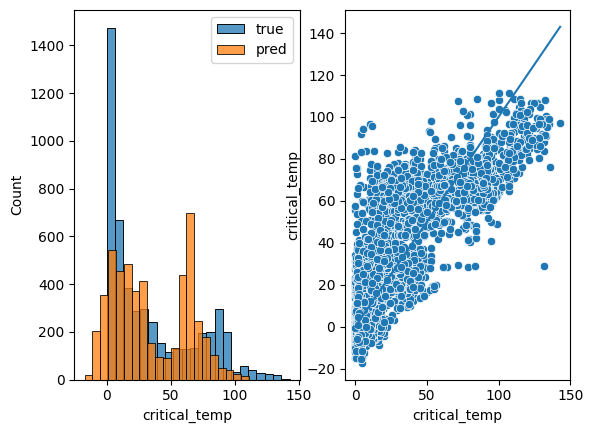

In [41]:
get_pred_plot(test[y_col], lasso.predict(test[X_col]), filter=False)

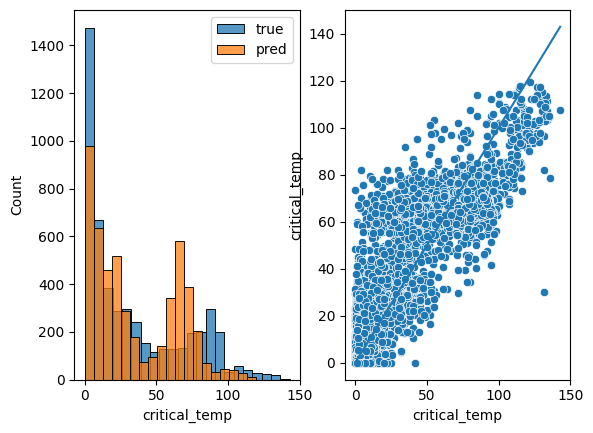

In [42]:
get_pred_plot(test[y_col], lm.predict(test[X_col]), filter=True)

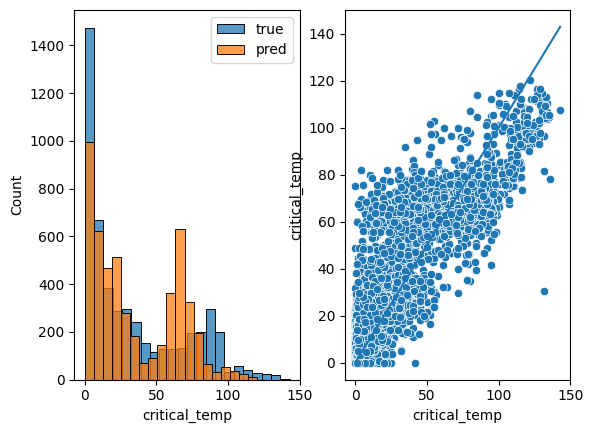

In [43]:
get_pred_plot(test[y_col], ridge.predict(test[X_col]), filter=True)

## Decision tree

Для проверки других моделей машинного обучения для задачи регрессии разделим тестовую выборку еще на две, чтобы подбирать гиперпараметры у более сложных моделей

In [45]:
valid, test = train_test_split(test, train_size=0.5, random_state=54152)

In [46]:
dt = DecisionTreeRegressor(max_depth=14, criterion='squared_error', min_samples_split=10)
dt.fit(train[X_col], train[y_col])

dt_metric = pd.concat([
    get_metric(train[y_col], dt.predict(train[X_col])),
    get_metric(valid[y_col], dt.predict(valid[X_col])),
    get_metric(test[y_col], dt.predict(test[X_col])),
])
dt_metric.index = ['dt_train', 'dt_valid', 'dt_test']
dt_metric

,MSE,RMSE,MAE,R2
dt_train,59.201403,7.694245,4.446518,0.949713
dt_valid,151.594169,12.312358,6.861704,0.873838
dt_test,151.006643,12.288476,7.105653,0.870175


Для деерва решений R2 увеличился примерно на 10%, а средняя ошибка упала на 5 ед.

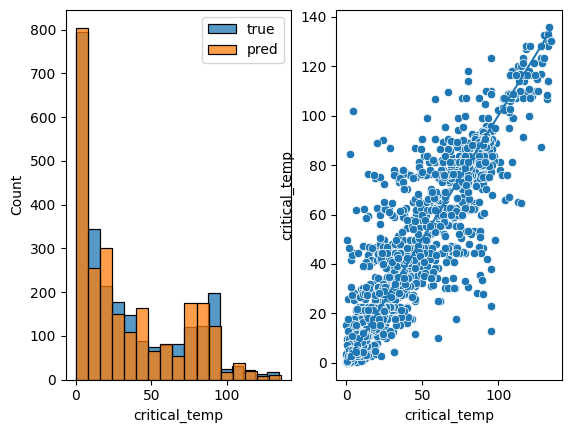

In [47]:
get_pred_plot(test[y_col], dt.predict(test[X_col]))

График распределения спрогнозированных признаков ближе к истинному, чем для линейной регрессии

Посмотрим на feature_importance деерва

In [48]:
dt_fi = pd.DataFrame({
    'feature_name':dt.feature_names_in_,
    'importance':dt.feature_importances_
})
dt_fi.sort_values('importance', ascending=False)

,feature_name,importance
104,Cu,0.631162
95,Ca,0.052926
33,wtd_gmean_Density,0.042867
129,Ba,0.040651
72,gmean_Valence,0.021810
...,...,...
143,Lu,0.000000
151,Au,0.000000
150,Pt,0.000000
148,Os,0.000000


Сравним feature_importance дерева и коэффициенты, полученные для регуляризованной регрессии

In [49]:
dt_fi.merge(reg_coef, on='feature_name')[['feature_name', 'lasso_wi', 'importance']].sort_values('importance', ascending=False)

,feature_name,lasso_wi,importance
104,Cu,-0.000000,0.631162
95,Ca,0.000000,0.052926
33,wtd_gmean_Density,0.001554,0.042867
129,Ba,5.324720,0.040651
72,gmean_Valence,-0.000000,0.021810
...,...,...,...
143,Lu,0.000000,0.000000
151,Au,-0.000000,0.000000
150,Pt,0.000000,0.000000
148,Os,0.000000,0.000000


- кроме меди нет признаков, которые бы выделялись по значению fi
- Коэффициенты для признаков с нибольшим fi получили нулевое значение

In [50]:
df['Cu'].describe()

count    17010.000000
mean         1.275659
std          2.120479
min          0.000000
25%          0.000000
50%          0.932500
75%          2.800000
max         98.000000
Name: Cu, dtype: float64

## RandomForest

In [60]:
rf = RandomForestRegressor(n_estimators=100, max_depth=10, min_samples_leaf=10, n_jobs=6)
rf.fit(train[X_col], train[y_col])
rf_metric = pd.concat([
    get_metric(train[y_col], rf.predict(train[X_col])),
    get_metric(valid[y_col], rf.predict(valid[X_col])),
    get_metric(test[y_col], rf.predict(test[X_col])),
])

In [58]:
rf_metric

,MSE,RMSE,MAE,R2
0,171.102370,13.080610,8.713837,0.854662
0,188.541580,13.731044,9.073295,0.843089
0,178.926889,13.376356,9.126027,0.846171


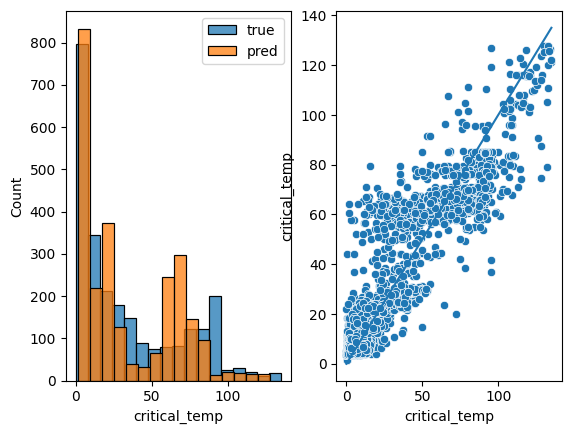

In [59]:
get_pred_plot(test[y_col], rf.predict(test[X_col]))

## CatBoost

In [68]:
boost = CatBoostRegressor(
    learning_rate=15e-3,
    max_depth=10,
    n_estimators=1000,
    verbose=100,
    random_state=1635
    )
boost.fit(train[X_col], train[y_col])

0:	learn: 34.0049550	total: 123ms	remaining: 2m 2s
100:	learn: 15.1253123	total: 19.3s	remaining: 2m 51s
200:	learn: 11.5266402	total: 38.3s	remaining: 2m 32s
300:	learn: 10.4305287	total: 56.8s	remaining: 2m 11s
400:	learn: 9.8211659	total: 1m 15s	remaining: 1m 53s
500:	learn: 9.4083064	total: 1m 34s	remaining: 1m 33s
600:	learn: 9.0536648	total: 1m 52s	remaining: 1m 14s
700:	learn: 8.7112678	total: 2m 14s	remaining: 57.4s
800:	learn: 8.4126692	total: 2m 33s	remaining: 38.1s
900:	learn: 8.1943076	total: 2m 51s	remaining: 18.9s
999:	learn: 7.9761174	total: 3m 10s	remaining: 0us


In [69]:
cat_boost_metric = pd.concat([
    get_metric(train[y_col], boost.predict(train[X_col])),
    get_metric(valid[y_col], boost.predict(valid[X_col])),
    get_metric(test[y_col], boost.predict(test[X_col])),
])
cat_boost_metric.index = ['boost_train', 'boost_valid', 'boost_test']
cat_boost_metric

,MSE,RMSE,MAE,R2
boost_train,63.618449,7.976117,5.215093,0.946246
boost_valid,115.612901,10.752344,6.531774,0.899945
boost_test,106.415211,10.315775,6.280822,0.909775


Получили наилучшие метрики из всех предыдущих моделей, но потребовалось слишком большое кол-во итераций, чтобы догнать по точности дерево решений
- при этом без *тонкой* настройки всевозможных  гиперпараметров catboost'а пришлось выбрать большую глубины и большой lr, чтобы получить точность выше, чем у обычного дерева решений   

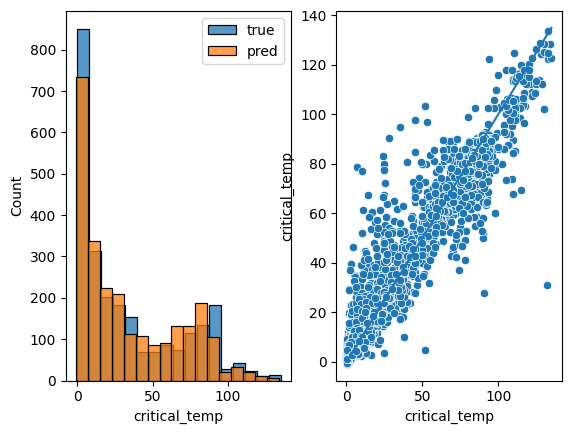

In [70]:
get_pred_plot(test[y_col], boost.predict(test[X_col]))

In [71]:
boost_fi = pd.DataFrame({
    'feature_name':boost.feature_names_,
    'importance':boost.feature_importances_
})
boost_fi.sort_values('importance', ascending=False)

,feature_name,importance
104,Cu,14.357990
95,Ca,7.602646
129,Ba,5.217218
71,wtd_mean_Valence,4.697760
49,wtd_std_ElectronAffinity,2.269969
...,...,...
143,Lu,0.000000
147,Re,0.000000
145,Ta,0.000000
151,Au,0.000000


Первые 4 эл-та, отсортированные по fi, совпадают с эл-ми для дерва решений, но немного отличается их порядок

Также получили отрицательные спрогнозированные значения, для дерева решений такого невозоможно
